In [16]:
import numpy as np

from genriesz import (
    grr_functional,
    grr_ate,  # Add the convenience wrapper
    ATEFunctional,
    SquaredGenerator,
    PolynomialBasis,
    TreatmentInteractionBasis,
)

rng = np.random.default_rng(0)

# Simple Example: Using `grr_functional` 

This notebook demonstrates how to use `grr_functional` to estimate linear functionals using Generalized Riesz Regression (GRR).

## What is `grr_functional`?

`grr_functional` is the most general entry point for estimating linear functionals like:
- **ATE** (Average Treatment Effect): E[Y(1) - Y(0)]
- **ATT** (Average Treatment Effect on Treated)
- **AME** (Average Marginal Effect)
- Custom functionals you define

## What you provide:

1. **Data**: `(X, Y)` where X includes covariates and treatment
2. **Functional**: `m(x, gamma)` - what you want to estimate
3. **Basis function**: `phi(X)` - feature map for the design matrix
4. **Bregman generator**: Defines the link function

## What you get:

Multiple robust estimators:
- **RA** (Regression Adjustment / Plug-in)
- **RW** (Riesz Weighting / IPW)
- **ARW** (Augmented Riesz Weighting / AIPW) - **doubly robust!**
- **TMLE** (Targeted Maximum Likelihood Estimation)

This notebook shows **3 methods** of increasing flexibility.

In [17]:
# Generate synthetic data with binary treatment
n = 500
d = 3

# Covariates
Z = rng.normal(size=(n, d))

# Binary treatment (with some confounding)
logits = 0.5 * Z[:, 0] - 0.3 * Z[:, 1]
propensity = 1.0 / (1.0 + np.exp(-logits))
D = rng.binomial(1, propensity, size=n)

# Outcome with treatment effect = 2.0
true_tau = 2.0
Y0 = Z[:, 0] + 0.5 * Z[:, 1]**2  # baseline outcome
Y = Y0 + true_tau * D + rng.normal(scale=0.5, size=n)

# Combine treatment and covariates
X = np.column_stack([D, Z])

print(f"Sample size: {n}")
print(f"True treatment effect: {true_tau}")
print(f"Treatment rate: {D.mean():.3f}")

Sample size: 500
True treatment effect: 2.0
Treatment rate: 0.482


In [18]:
# Define a basis function: polynomial features with treatment interactions
def basis(X):
    """
    X: (n, 4) array with columns [D, Z1, Z2, Z3]
    Returns: (n, p) basis expansion
    """
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        # Single row case
        D = X[0]
        Z = X[1:]
        return np.array([1.0, D, Z[0], Z[1], Z[2], D*Z[0], D*Z[1], D*Z[2]])
    else:
        # Multiple rows
        D = X[:, 0:1]
        Z = X[:, 1:]
        return np.column_stack([
            np.ones(len(X)),      # intercept
            D,                     # treatment
            Z,                     # covariates
            D * Z                  # treatment × covariates interactions
        ])

print("Basis dimension:", basis(X).shape[1])

Basis dimension: 8


In [19]:
# Method 1: Using grr_ate convenience wrapper (RECOMMENDED)
# ============================================================
# This is the simplest way for common estimands like ATE

generator = SquaredGenerator(C=0.0).as_generator()

result_ate = grr_ate(
    X=X,                      # data including treatment
    Y=Y,                      # outcomes
    basis=basis,              # basis function
    generator=generator,      # Bregman generator
    treatment_index=0,        # treatment is in column 0
    cross_fit=True,           # use cross-fitting for robustness
    folds=5,                  # 5-fold cross-fitting
    random_state=42
)

print("=" * 60)
print("METHOD 1: grr_ate convenience wrapper")
print("=" * 60)
print(result_ate.summary_text())
print(f"\nTrue treatment effect = {true_tau}")
print("\nEstimators explained:")
print("  - DM (Direct Method) = RA (Regression Adjustment)")
print("  - IPW (Inverse Propensity Weighting) = RW (Riesz Weighting)")
print("  - AIPW (Augmented IPW) = ARW (Augmented Riesz Weighting)")
print("    AIPW is doubly robust: consistent if either outcome or")
print("    propensity model is correct")

METHOD 1: grr_ate convenience wrapper
n=500, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  2.114246  (se=0.080819)  CI[95%]=1.955843,2.272648  p=0
   DM (shared):  2.123137  (se=0.014335)  CI[95%]=2.095042,2.151233  p=0
           IPW:  2.146227  (se=0.160227)  CI[95%]=1.832187,2.460267  p=0

True treatment effect = 2.0

Estimators explained:
  - DM (Direct Method) = RA (Regression Adjustment)
  - IPW (Inverse Propensity Weighting) = RW (Riesz Weighting)
  - AIPW (Augmented IPW) = ARW (Augmented Riesz Weighting)
    AIPW is doubly robust: consistent if either outcome or
    propensity model is correct


In [20]:
# Method 2: Using grr_functional with ATEFunctional (MORE FLEXIBLE)
# ===================================================================
# This approach allows custom functionals beyond the built-in wrappers

m = ATEFunctional(
    treatment_index=0,      # D is in the first column of X
    treat_value_1=1.0,      # treated value
    treat_value_0=0.0       # control value
)

result_functional = grr_functional(
    X=X,
    Y=Y,
    m=m,                    # the functional to estimate
    basis=basis,
    generator=generator,
    cross_fit=True,
    folds=5,
    random_state=42
)

print("\n" + "=" * 60)
print("METHOD 2: grr_functional with ATEFunctional")
print("=" * 60)
print(result_functional.summary_text())
print(f"\nTrue treatment effect = {true_tau}")


METHOD 2: grr_functional with ATEFunctional
n=500, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  2.114246  (se=0.080819)  CI[95%]=1.955843,2.272648  p=0
   DM (shared):  2.123137  (se=0.014335)  CI[95%]=2.095042,2.151233  p=0
           IPW:  2.146227  (se=0.160227)  CI[95%]=1.832187,2.460267  p=0

True treatment effect = 2.0


In [21]:
# Accessing individual estimates from the result object
# ======================================================

print("\n" + "=" * 60)
print("ACCESSING INDIVIDUAL RESULTS")
print("=" * 60)

# Results are stored in the estimates dictionary
for name, est in result_ate.estimates.items():
    print(f"\n{name}:")
    print(f"  Point estimate: {est.estimate:.4f}")
    print(f"  Standard error: {est.stderr:.4f}")
    print(f"  95% CI: [{est.ci_low:.4f}, {est.ci_high:.4f}]")
    print(f"  p-value: {est.p_value:.6f}")
    print(f"  Reject H0 (θ=0)? {est.p_value < 0.05}")


ACCESSING INDIVIDUAL RESULTS

ipw:
  Point estimate: 2.1462
  Standard error: 0.1602
  95% CI: [1.8322, 2.4603]
  p-value: 0.000000
  Reject H0 (θ=0)? True

dm_shared:
  Point estimate: 2.1231
  Standard error: 0.0143
  95% CI: [2.0950, 2.1512]
  p-value: 0.000000
  Reject H0 (θ=0)? True

aipw_shared:
  Point estimate: 2.1142
  Standard error: 0.0808
  95% CI: [1.9558, 2.2726]
  p-value: 0.000000
  Reject H0 (θ=0)? True


In [22]:
# Method 3: Using a custom functional (MOST FLEXIBLE)
# ====================================================
# For advanced users: define your own m(x, gamma) function

def custom_m(x, gamma):
    """
    Custom functional: E[Y | D=1] - E[Y | D=0]
    
    x: single observation [D, Z1, Z2, Z3]
    gamma: fitted outcome model (callable)
    """
    x = np.asarray(x, dtype=float)
    x1 = x.copy()
    x0 = x.copy()
    x1[0] = 1.0  # set treatment to 1
    x0[0] = 0.0  # set treatment to 0
    return gamma(x1) - gamma(x0)

# Note: Using custom callable functionals requires the outcome model
# to be specified. The built-in functionals (like ATEFunctional) have
# optimized vectorized implementations.

result_custom = grr_functional(
    X=X,
    Y=Y,
    m=custom_m,
    basis=basis,
    generator=generator,
    cross_fit=True,
    folds=5,
    random_state=42
)

print("\n" + "=" * 60)
print("METHOD 3: grr_functional with custom m(x, gamma)")
print("=" * 60)
print(result_custom.summary_text())
print(f"\nTrue treatment effect = {true_tau}")


METHOD 3: grr_functional with custom m(x, gamma)
n=500, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  2.114246  (se=0.080819)  CI[95%]=1.955843,2.272648  p=0
   DM (shared):  2.123137  (se=0.014335)  CI[95%]=2.095042,2.151233  p=0
           IPW:  2.146227  (se=0.160227)  CI[95%]=1.832187,2.460267  p=0

True treatment effect = 2.0


## Summary

All three methods produce the same estimates (as expected):
- All estimates are close to the true treatment effect of 2.0
- **AIPW/ARW** is doubly robust and typically preferred
- **DM/RA** has the smallest standard error (but not robust if the model is misspecified)
- **IPW/RW** has the largest standard error (high variance)

### When to use which method?

1. **Method 1 (`grr_ate`)**: Use for common estimands (ATE, ATT, AME, DID)
   - Simplest and most convenient
   - Optimized vectorized implementation
   
2. **Method 2 (`grr_functional` + built-in functional)**: Use when you need:
   - More control over the estimation process
   - Custom basis functions or outcome models
   - Same built-in functionals as Method 1
   
3. **Method 3 (custom `m(x, gamma)`)**: Use when:
   - You need a completely custom functional
   - The built-in functionals don't cover your use case
   - You're prototyping new estimands

### Key features:
- **Cross-fitting**: Reduces overfitting bias (default: 5 folds)
- **Multiple estimators**: Compare RA, RW, ARW, TMLE
- **Doubly robust**: ARW/AIPW is consistent if *either* outcome or propensity model is correct

## Accessing the Riesz Representer Weights (alpha)

The result object stores the computed alpha weights for each observation!

In [23]:
# Access the alpha weights from the result object
alpha_weights = result_ate.alpha_hat

print("Alpha weights (Riesz representer):")
print(f"  Shape: {alpha_weights.shape}")
print(f"  Mean: {alpha_weights.mean():.6f}")
print(f"  Std: {alpha_weights.std():.6f}")
print(f"  Min: {alpha_weights.min():.6f}")
print(f"  Max: {alpha_weights.max():.6f}")
print(f"\nFirst 10 weights: {alpha_weights[:10]}")

Alpha weights (Riesz representer):
  Shape: (500,)
  Mean: 0.004340
  Std: 2.087006
  Min: -3.324378
  Max: 3.980014

First 10 weights: [ 2.06913301 -2.22609315  1.69155604 -1.84812313 -1.15685408 -1.9038657
  2.06247231  1.08216253 -2.3918514  -1.79721048]


In [24]:
# The result object also contains other nuisance parameters:
print("Other nuisance parameters available:")
print(f"  alpha_hat: {result_ate.alpha_hat is not None} (shape: {result_ate.alpha_hat.shape if result_ate.alpha_hat is not None else 'N/A'})")
print(f"  gamma_hat_shared: {result_ate.gamma_hat_shared is not None} (outcome model predictions)")
print(f"  m_hat_shared: {result_ate.m_hat_shared is not None} (functional evaluations)")

# Verify the RW estimator manually using alpha weights
rw_manual = np.mean(alpha_weights * Y)
rw_from_result = result_ate.estimates['ipw'].estimate

print(f"\n✓ Manual RW calculation: {rw_manual:.6f}")
print(f"✓ RW from result:        {rw_from_result:.6f}")
print(f"✓ Match: {np.isclose(rw_manual, rw_from_result)}")

Other nuisance parameters available:
  alpha_hat: True (shape: (500,))
  gamma_hat_shared: True (outcome model predictions)
  m_hat_shared: True (functional evaluations)

✓ Manual RW calculation: 2.146227
✓ RW from result:        2.146227
✓ Match: True


/var/folders/h2/1s7_1qmn5lv9mlp14wkr35sw0000gn/T/ipykernel_97747/2319061494.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([alpha_weights[control], alpha_weights[treated]],


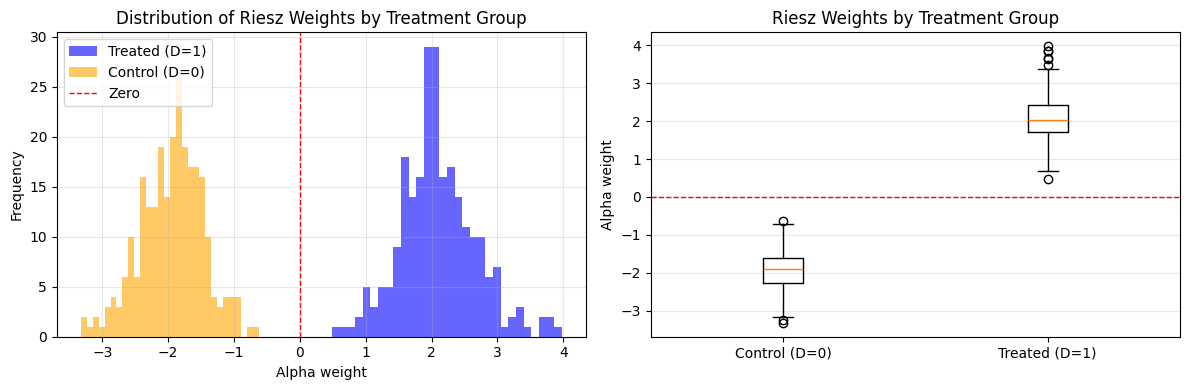

Mean alpha | Treated: 2.096808
Mean alpha | Control: -1.942706


In [25]:
# Visualize alpha weights by treatment group
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Split by treatment status
treated = D == 1
control = D == 0

# Histogram
axes[0].hist(alpha_weights[treated], alpha=0.6, bins=30, label='Treated (D=1)', color='blue')
axes[0].hist(alpha_weights[control], alpha=0.6, bins=30, label='Control (D=0)', color='orange')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
axes[0].set_xlabel('Alpha weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Riesz Weights by Treatment Group')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([alpha_weights[control], alpha_weights[treated]], 
                 labels=['Control (D=0)', 'Treated (D=1)'])
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_ylabel('Alpha weight')
axes[1].set_title('Riesz Weights by Treatment Group')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean alpha | Treated: {alpha_weights[treated].mean():.6f}")
print(f"Mean alpha | Control: {alpha_weights[control].mean():.6f}")

In [26]:
# Understanding the alpha weights:
print("Interpretation of Alpha Weights for ATE:")
print("=" * 60)
print(f"• Treated units (D=1): positive weights (mean ≈ {alpha_weights[treated].mean():.2f})")
print(f"• Control units (D=0): negative weights (mean ≈ {alpha_weights[control].mean():.2f})")
print(f"\nThe RW/IPW estimator computes: E[α(X) · Y] = {np.mean(alpha_weights * Y):.4f}")
print(f"  = {alpha_weights[treated].mean():.3f} × E[Y|D=1] - {abs(alpha_weights[control].mean()):.3f} × E[Y|D=0]")
print(f"  ≈ E[Y(1)] - E[Y(0)]  (the ATE)")
print(f"\nThese weights balance covariates to make treatment/control comparable.")
print(f"They generalize inverse propensity weights to arbitrary functionals!")

Interpretation of Alpha Weights for ATE:
• Treated units (D=1): positive weights (mean ≈ 2.10)
• Control units (D=0): negative weights (mean ≈ -1.94)

The RW/IPW estimator computes: E[α(X) · Y] = 2.1462
  = 2.097 × E[Y|D=1] - 1.943 × E[Y|D=0]
  ≈ E[Y(1)] - E[Y(0)]  (the ATE)

These weights balance covariates to make treatment/control comparable.
They generalize inverse propensity weights to arbitrary functionals!
